# Preprocessing 
Data preprocessing for mediation analysis, focusing on causaly suspected features.

Grouping diffenet early adversery events (EAE) and extracting addictions, as the analysis can be performed for various kind of substance use disorders (suffix X-'ud') and not only CUD (also 'maud').

In [3]:
import pandas as pd
import numpy as np
from patsy import dmatrices
from scipy.stats import pearsonr
from scipy.special import betainc 
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sl
from sklearn import linear_model, datasets, preprocessing, metrics
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import LogisticRegressionCV
import pickle as pkl
from tempfile import TemporaryFile
import seaborn as sns


In [4]:
# function to convert to float
def convert_float(val):
    try:
        return float(val)
    except ValueError:
        return np.nan
    
# function to convert to string
def convert_string(val):
    try:
        return str(val)
    except ValueError:
        return ''

In [5]:
# read data
DB = pd.read_csv("wave3_NS4.csv")

# Convert to string
DB = DB.astype(str)
DB.columns = [x.lower() for x in DB.columns]

C:\Users\Bar\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (133,142,146,159,601,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,656,658,2765,2766,3352,3357,4063,4064,4065,4067,4100,4101,4102,4103,4104,4105,4106,4107,4108,4109,4110,4111,4112,4113,4114,4115,4116,4117,4118,4119,4120,4121,4122,4123,4124,4125,4126,4127,4128,4129,4130,4131,4132,4133,4134,4135,4136,4137,4138,4139,4140,4141,4142,4143,4144,4145,4146,4147,4148,4149,4150,4151,4152,4153,4154,4155,4156,4157,4158,4159,4160,4161,4162,4163,4164,4165,4166,4167,4168,4169,4170,4171,4172,4173,4174,4175,4176,4177,4178,4179,4180,4181,4182,4183,4184,4185,4186,4187,4188,4189,4190,4191,4192,4193,4194,4195,4196,4197,4198,4199,4200,4216,4217,4218,4219,4220,4221,4222,4223,4224,4225,4226,4227,4228,4229,4230,4231,4232,4233,4234,4386,4398,4399,4400,4401,4402,4403,4404,4405,4406,4407,4408,4409,4410,4411,4412,4413,4414,4415,4416,4417,4418,4419,4420,4421,4422,4423,4424,4425,4426

In [6]:
# read Variables For Use with Causal Potential

VariablesForUse = pd.read_csv("Causal_suspected.csv")
VariablesForUse = np.squeeze(VariablesForUse.values)
df = DB[VariablesForUse]

In [8]:
dfContinuousVars = df.loc[:, df.nunique() > 14]
dfCategorialVars = df.loc[:, df.nunique() <= 14]
print(f'dfCategorialVars is {dfCategorialVars.shape}')
print(f'dfContinuousVars is {dfContinuousVars.shape}')


dfCategorialVars is (36309, 12)
dfContinuousVars is (36309, 5)


In [9]:
pd.get_dummies(data=dfCategorialVars).columns

Index(['nsex_1', 'nsex_2', 'age_cat_1', 'age_cat_2', 'age_cat_3', 'age_cat_4',
       'nethrace_1', 'nethrace_2', 'nethrace_3', 'nethrace_4', 'nethrace_5',
       'race_dicho_1', 'race_dicho_2', 'n14q7_1', 'n14q7_2', 'n14q7_3',
       'n14q7_4', 'n14q7_9', 'sexor_dicho_ ', 'sexor_dicho_1', 'sexor_dicho_2',
       'eae_passive_ ', 'eae_passive_0', 'eae_passive_1', 'eae_fam_men_ill_ ',
       'eae_fam_men_ill_0', 'eae_fam_men_ill_1', 'eae_emotional_neglect_ ',
       'eae_emotional_neglect_0', 'eae_emotional_neglect_1', 'eae_neglect_ ',
       'eae_neglect_0', 'eae_neglect_1', 'eae_violence_ ', 'eae_violence_0',
       'eae_violence_1', 'eae_sexual_ ', 'eae_sexual_0', 'eae_sexual_1'],
      dtype='object')

In [10]:
# bianry dummies
dfCategorialVars = pd.get_dummies(data=dfCategorialVars)
dfCategorialVars.drop(columns=['nsex_2','race_dicho_2'], inplace=True)

print(f'dfCategorialVars is {dfCategorialVars.shape}')

for col in dfContinuousVars:
    dfContinuousVars[col] = dfContinuousVars[col].apply(lambda j: convert_float(j)) # Change df values from string to float
    unique = dfContinuousVars[col]
    dfContinuousVars[col] = pd.cut(x=unique, bins=5, labels=['1','2','3','4','5']) #change from real values to the quintiles of each variable
dfContinuousVars.shape

dfContinuousVars = pd.get_dummies(data=dfContinuousVars)
print(f'dfContinuousVars is {dfContinuousVars.shape}')

dfCategorialVars is (36309, 37)
dfContinuousVars is (36309, 25)


<ipython-input-10-8dbaff512b19>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfContinuousVars[col] = dfContinuousVars[col].apply(lambda j: convert_float(j)) # Change df values from string to float
<ipython-input-10-8dbaff512b19>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfContinuousVars[col] = pd.cut(x=unique, bins=5, labels=['1','2','3','4','5']) #change from real values to the quintiles of each variable


In [11]:
# merge 
dfMerged = pd.concat([dfCategorialVars, dfContinuousVars], axis=1)
dfMerged.shape

dfMerged['eae_violence_1'] = pd.Series(np.zeros(dfMerged.shape[0]))
dfMerged['eae_violence_1'][DB['eae_violence'] == '1'] = 1

dfMerged['eae_sexual_1'] = pd.Series(np.zeros(dfMerged.shape[0]))
dfMerged['eae_sexual_1'][DB['eae_sexual'] == '1'] = 1
dfMerged['eae_sexual_1'].value_counts()


<ipython-input-11-fbbd86866ed4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfMerged['eae_violence_1'][DB['eae_violence'] == '1'] = 1
<ipython-input-11-fbbd86866ed4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfMerged['eae_sexual_1'][DB['eae_sexual'] == '1'] = 1


0.0    32138
1.0     4171
Name: eae_sexual_1, dtype: int64

In [13]:
# keep feature names
feature_names = dfMerged.columns.values

# array of dfCategorialVars
x = np.array(dfMerged)

#  "y"
y = DB[['maud5']]
y =y.astype(float) 
y = np.ravel(y)

# keep weights - the audweight
weights = DB[['audweight']]
weights =weights.astype(float) 
weights = np.ravel(weights)

np.save('weights.npy', weights)

In [17]:
for isel in ['isel_app','isel_bel','isel_tan']:
    
    temp = DB[isel].apply(lambda j: convert_float(j)) # Change df values from string to float
    unique = temp
    temp = pd.cut(x=unique, bins=5, labels=['1','2','3','4','5']) #change from real values to the quintiles of each variable

    b = pd.get_dummies(temp, prefix=isel) 
    dfMerged = pd.concat([dfMerged,b], axis=1)

dfMerged.columns

Index(['nsex_1', 'age_cat_1', 'age_cat_2', 'age_cat_3', 'age_cat_4',
       'nethrace_1', 'nethrace_2', 'nethrace_3', 'nethrace_4', 'nethrace_5',
       'race_dicho_1', 'n14q7_1', 'n14q7_2', 'n14q7_3', 'n14q7_4', 'n14q7_9',
       'sexor_dicho_ ', 'sexor_dicho_1', 'sexor_dicho_2', 'eae_passive_ ',
       'eae_passive_0', 'eae_passive_1', 'eae_fam_men_ill_ ',
       'eae_fam_men_ill_0', 'eae_fam_men_ill_1', 'eae_emotional_neglect_ ',
       'eae_emotional_neglect_0', 'eae_emotional_neglect_1', 'eae_neglect_ ',
       'eae_neglect_0', 'eae_neglect_1', 'eae_violence_ ', 'eae_violence_0',
       'eae_violence_1', 'eae_sexual_ ', 'eae_sexual_0', 'eae_sexual_1',
       'fam_percep_b4_18_1', 'fam_percep_b4_18_2', 'fam_percep_b4_18_3',
       'fam_percep_b4_18_4', 'fam_percep_b4_18_5', 'alc_init_age_1',
       'alc_init_age_2', 'alc_init_age_3', 'alc_init_age_4', 'alc_init_age_5',
       'nico_init_age_1', 'nico_init_age_2', 'nico_init_age_3',
       'nico_init_age_4', 'nico_init_age_5', 'cann

In [18]:
import scipy.stats  as stats

colnames = ['pyaud5','ppyaud5','nicdep5','pnicdep5','any_sud_py', 'any_sud_ppy','any_disphor_py','any_disphor_ppy','pmaud5',
            'any_anx_py','any_manic_py','eatd_py','personality_dis2','relig_dich']

Extradf = DB[colnames]
Extradf['maud5'] = DB[['maud5']]
dummies_list = []

Extradf.replace(" ", np.nan, inplace=True)
Extradf = Extradf.astype(float)
Extradf.fillna(Extradf.mean, inplace=True)
Extradf = pd.get_dummies(data=Extradf, drop_first=True)


<ipython-input-18-4971d9183776>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Extradf['maud5'] = DB[['maud5']]
C:\Users\Bar\Anaconda3\lib\site-packages\pandas\core\frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [19]:
#Create sud var - everything but nicotine
Extradf['anysud_maud'] = pd.Series(np.zeros(dfMerged.shape[0]))
Extradf.loc[(Extradf['maud5'] == 1) | (Extradf['any_sud_py'] == 1), 'anysud_maud'] = 1 
print(Extradf['anysud_maud'].value_counts())

#Any sud
Extradf['All_sud'] = pd.Series(np.zeros(dfMerged.shape[0]))
Extradf.loc[(Extradf['pyaud5'] == 1) | (Extradf['anysud_maud'] == 1), 'All_sud'] = 1 
Extradf['All_sud'].value_counts()

0.0    34822
1.0     1487
Name: anysud_maud, dtype: int64


0.0    30501
1.0     5808
Name: All_sud, dtype: int64

In [20]:
df = pd.DataFrame()
#Additional vars

dfMerged['impulsive_1'] = np.where(DB.eval('n10q1a29 == "1"'), 1, 0)
dfMerged['impulsive_1'].value_counts()

dfMerged.loc[(DB['n10q1a29'] == '1') | (DB['n2dq2'] == '1')| (DB['n2dq3c2'] == '1')| (DB['n2dq4c2'] == '1') | (DB['n2dq14a'] == '1')| (DB['n2dq14b'] == '1'), 'fam_pyaud'] = 1
dfMerged.loc[(DB['n3eq1'] == '1') | (DB['n3eq2'] == '1')| (DB['n3eq3c'] == '1')| (DB['n3eq4c'] == '1') , 'fam_sud_non_alc'] = 1

dfMerged.loc[(dfMerged['fam_pyaud'] == 1) | (dfMerged['fam_sud_non_alc'] == 1) , 'any_fam_sud'] = 1

dfMerged['conduct_disorder'] = np.where(DB.eval('conductso == "1"'), 1, 0)

dfMerged['eae_passive_1'] = np.where(dfMerged.eval('eae_passive_0 == 0.0'), 1, 0)
dfMerged['eae_neglect_1'] = np.where(dfMerged.eval('eae_neglect_0 == 0.0'), 1, 0)
dfMerged['eae_sexual_1'] = np.where(dfMerged.eval('eae_sexual_0 == 0.0'), 1, 0)

dfMerged.loc[(dfMerged['eae_violence_1'] == 1) | (dfMerged['eae_sexual_1'] == 1) , 'eae_violence_sexaul'] = 1
dfMerged.loc[(dfMerged['eae_passive_1'] == 1) | (dfMerged['eae_neglect_1'] == 1) , 'eae_passive_neglect'] = 1 
dfMerged.loc[(dfMerged['eae_passive_neglect'] == 1) | (dfMerged['eae_violence_sexaul'] == 1) , 'All_EAE'] = 1
dfMerged.fillna(0, inplace=True)

print(dfMerged['eae_violence_sexaul'].value_counts())
print(dfMerged['eae_passive_neglect'].value_counts())
print(dfMerged['All_EAE'].value_counts())


0.0    21908
1.0    14401
Name: eae_violence_sexaul, dtype: int64
0.0    20265
1.0    16044
Name: eae_passive_neglect, dtype: int64
1.0    21411
0.0    14898
Name: All_EAE, dtype: int64


[Text(0.5, 1.0, 'CUD in subjects who experienced violent EAE')]

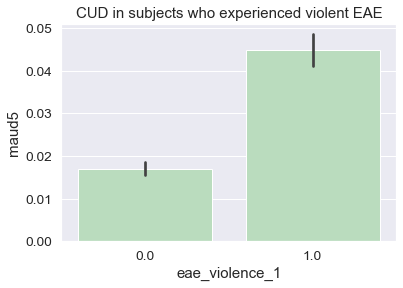

In [106]:
More = pd.concat([dfMerged , Extradf], axis=1)
More = More.astype(float)

sns.set(font_scale=1.25)
pal = sns.color_palette("GnBu_d", len(More))
sns.barplot(x = 'eae_violence_1', y = 'maud5', data=More, palette=np.array(pal[::-1])).set(title='CUD in subjects who experienced violent EAE')


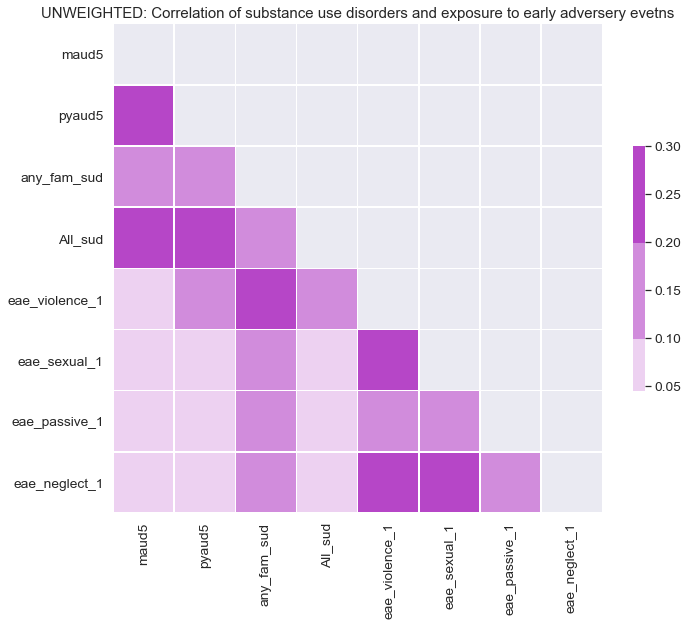

In [97]:
# plt.matshow(More[['maud5','pyaud5', 'any_fam_sud', 'All_sud', 'eae_violence_sexaul', 'eae_passive_neglect']].corr())
# plt.show()
corr = More[['maud5','pyaud5', 'any_fam_sud', 'All_sud', 'eae_violence_1', 'eae_sexual_1', 'eae_passive_1', 'eae_neglect_1']].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 300, as_cmap=False)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(title='UNWEIGHTED: Correlation of substance use disorders and exposure to early adversery evetns');

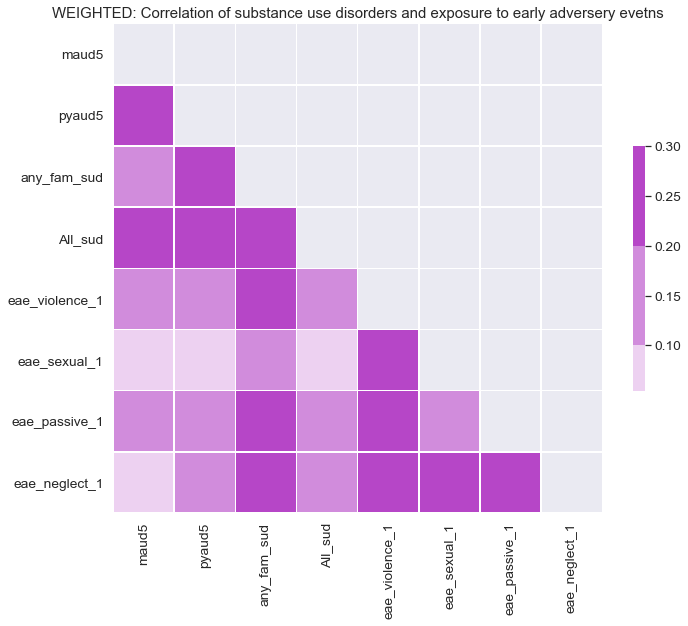

In [98]:
# Weighted correlation

df_w = More[['maud5','pyaud5', 'any_fam_sud', 'All_sud', 'eae_violence_1', 'eae_sexual_1', 'eae_passive_1', 'eae_neglect_1']].copy().astype(float)

# df_w['weights'] = DB[['maud5']].astype(float)

for col in df_w.columns:
    if col!='weights':
        df_w[col] = df_w[col] * weights
        

corr = df_w.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 300, as_cmap=False)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(title='WEIGHTED: Correlation of substance use disorders and exposure to early adversery evetns');

In [ ]:
More.to_csv('More.csv')